# Bayes Inference 

In [49]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pystan
import arviz as az

## Setup
### In words
What is the proportion of water on the globe, given measurements of random tosses?

This sample is taken from Richard Mcelreath from his book and his lecture

[Lecture](https://youtu.be/XoVtOAN0htU?t=278)

### In code
Usually this is done with numpy arrays, where water and land is encoded with 0 and 1 for success. I'm doing it here in two steps to highlight that the ones and zeros just stand for success and failure

In [2]:
observations = pd.Series(["w", "l", "w", "w", "w","l","w", "l", "w"])

# Convert to binomial representation
observations_binom = (observations == "w").astype(int).values
observations_binom

array([1, 0, 1, 1, 1, 0, 1, 0, 1])

In [3]:
water_observations = sum(observations_binom)
total_observations = len(observations_binom)

## Conjugate Prior
Just use the formula here and things magically work
https://en.wikipedia.org/wiki/Conjugate_prior

In [4]:
_alpha = 1 + water_observations
_beta = 1 + total_observations - water_observations

Text(0.5, 0.98, 'Exact Posterior through Conjugate Prior')

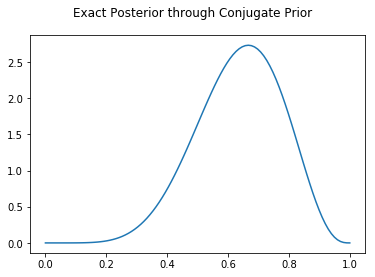

In [87]:
x = np.linspace(0,1,100)
posterior_conjugate = stats.beta.pdf(x, a=_alpha, b=_beta)

fig, ax = plt.subplots()
plt.plot(x,posterior_conjugate)
fig.suptitle("Exact Posterior through Conjugate Prior")

In [6]:
posterior_conjugate[20] / posterior_conjugate[70]

0.010997121265937769

In [7]:
np.log(posterior_conjugate[40]) - np.log(posterior_conjugate[70])

-1.2269698858547988

### Pros
* Posterior distribution is exact. It is *not* an estimation
* Most computationally efficient

### Cons
* Requires advanced math to create analytical solution
* Only simple problems have been solved (https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

## Grid Search
Steps
1. Generate a grid of points
2. Calculate likelihood for each point
3. For each beta take another grid of points to get probability
4. Calculate likelihood and posterior

In [8]:
possible_probabilities = np.linspace(0,1,100)
prior = np.repeat(5,100)
likelihood = stats.binom.pmf(water_observations, total_observations, possible_probabilities)

posterior_unstandardized = likelihood * prior
posterior_grid_search = posterior_unstandardized / sum(posterior_unstandardized)

Text(0.5, 0.98, 'Posterior through Grid Approximation')

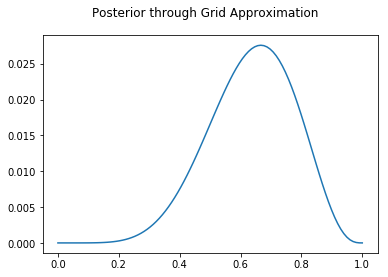

In [9]:
fig, ax = plt.subplots()
plt.plot(possible_probabilities, posterior_grid_search)
fig.suptitle("Posterior through Grid Approximation")

In [10]:
posterior_grid_search[20] / posterior_grid_search[70]

0.010997121265937769

In [11]:
np.log(posterior_grid_search[40]) - np.log(posterior_grid_search[70])

-1.2269698858547993

### Pros
* Conceptually simple
* Can theoretically be used to solve any problems

### Cons
* Combinatorics will mean that solution scales very poorly. Sun will explode before some models complete

## Quadratic (Laplace) Approximation
http://www.sumsar.net/blog/2013/11/easy-laplace-approximation/  
https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_02.ipynb

In [12]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=total_observations, p=p, observed=water_observations)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/home/canyon/miniconda3/envs/arviz/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1178.88it/s]


(array(0.66666667), array([0.15713484]))

Text(0.5, 0.98, 'Posterior Approximation through Quadratic Approximation')

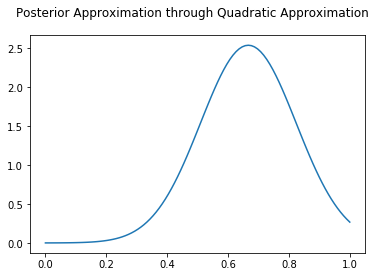

In [13]:
possible_probabilities = np.linspace(0,1,100)
posterior_laplace = stats.norm.pdf(possible_probabilities, mean_q['p'], std_q)
fig, ax = plt.subplots()
plt.plot(possible_probabilities, posterior_laplace)
fig.suptitle("Posterior Approximation through Quadratic Approximation")

In [14]:
posterior_laplace[40] / posterior_laplace[70]

0.255729157826732

### Pros
* Fast

### Cons
* Normal distributions can't approximate everything

## Markov Chain Monte Carlo

### "Hand built" Metroplis Hastings
https://twiecki.io/blog/2015/11/10/mcmc-sampling/  
http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

In [15]:
samples = 5000
proposal_width = .1
p_accept = .5

# Assume Normal Prior for this example
p_water_current = .5
p_water_prior_normal_mu = .5
p_water_prior_normal_sd = 1

mh_posterior = []
for i in range(samples):
    # Proposal Normal distribution
    p_water_proposal = stats.norm(p_water_current, proposal_width).rvs()
    
    # Calculate likelihood of each
    likelihood_current = stats.binom.pmf(water_observations, total_observations, p_water_current)
    likelihood_proposal = stats.binom.pmf(water_observations, total_observations, p_water_proposal)

    # Convert likelihoods that evaluate to nans to zero
    likelihood_current = np.nan_to_num(likelihood_current)
    likelihood_proposal = np.nan_to_num(likelihood_proposal)
    
    # Calculate prior value given proposal and current
    prior_current = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_current)
    prior_proposal = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_proposal)

    # Calculate posterior probability of current and proposals
    p_current = likelihood_current * prior_current
    p_proposal = likelihood_proposal * prior_proposal
    
    p_accept = p_proposal / p_current
    
    if np.random.rand() < p_accept:
        p_water_current = p_water_proposal
    
    assert p_water_current > 0

    mh_posterior.append(p_water_current)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c61965b38>],
      dtype=object)

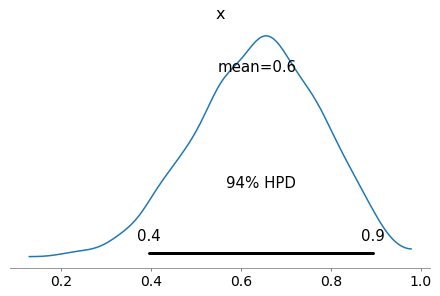

In [16]:
mh_posterior= np.asarray(mh_posterior)
az.plot_posterior(mh_posterior)

In [17]:
np.asarray(mh_posterior)

array([0.53757366, 0.53757366, 0.58773163, ..., 0.69477863, 0.69477863,
       0.74395622])

### Estimate local probability
Because MCMC provides samples and not an actual distribution, we have to take a ratio of counts, not a ratio of areas as before

In [46]:
def estimate_prob_ratio_from_samples(mcmc_posterior, prob_1=.4, prob_2=.7, width=.01):
    
    # We need to compare the same interval in the distribution as we did above
    # In the above case x[20] is .01 wide centered at 
    num_samples_1 = np.sum(np.isclose(prob_1, mcmc_posterior, rtol=0, atol=width))
    num_samples_2 = np.sum(np.isclose(prob_2, mcmc_posterior, rtol=0, atol=width))
    return num_samples_1/num_samples_2
    
estimate_prob_ratio_from_samples(mh_posterior)

0.31679389312977096

In [45]:
x[40]

0.4040404040404041

## PyMC3 MCMC Hamilton Monte Carlo (Specifically Nuts)
Probabilistic Programming languages simplify Bayesian modeling tremendously but letting letting the statistician focus on the model, and less so on the sampler or other mathematical details. From a s

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:16<00:00, 6129.23draws/s]
/home/canyon/repos/arviz/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c399aeba8>],
      dtype=object)

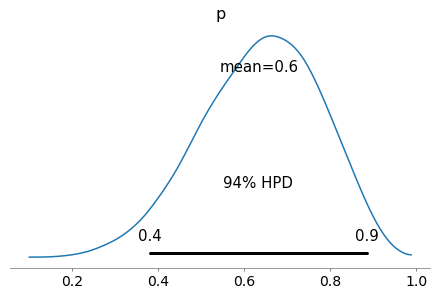

In [67]:
with pm.Model() as mcmc_nuts:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=total_observations, observed=water_observations)
    trace = pm.sample(50000, chains=2)
    
az.plot_posterior(trace)

In [47]:
pymc3_samples = trace.get_values("p")
estimate_prob_ratio_from_samples(samples, prob_1=.4, prob_2=.7)

0.27157104437471985

## Stan MCMC Hamilton Monte Carlo (Also Nuts)
We can build the same model in Stan as well

In [53]:
water_code = """
data {
    int<lower=0> water_observations; // number of water observations
    int<lower=0> number_of_tosses; // number of globe tosses
}

parameters {
    real p_water; // Proportion of water on globe
}

model {
    p_water~uniform(0.0,1.0);
    water_observations ~ binomial(number_of_tosses, p_water);
}
"""
water_dat = {'water_observations': 6,
               'number_of_tosses': 9}

sm = pystan.StanModel(model_code=water_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dedfcbf67db9d2d5064f58308236c51b NOW.


In [68]:
fit = sm.sampling(data=water_dat, iter=50000, chains=4)

In [69]:
stan_samples = fit["p_water"]
estimate_prob_ratio_from_samples(stan_samples, prob_1=.4, prob_2=.7)

0.2717842323651452

## PyMC3 ADVI

Average Loss = 2.3052: 100%|██████████| 50000/50000 [00:11<00:00, 4544.09it/s]
Finished [100%]: Average Loss = 2.3028
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 2.3028


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c29ec3a20>],
      dtype=object)

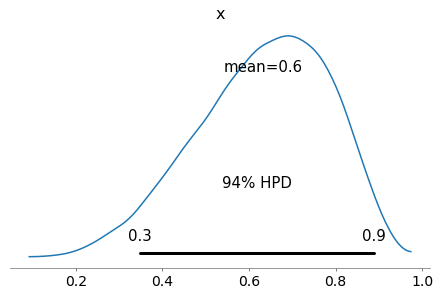

In [88]:
with pm.Model() as advi:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=total_observations, observed=water_observations)
    mean_field = pm.fit(method='advi', n=50000)

advi_samples = mean_field.sample(50000).get_values("p")
az.plot_posterior(advi_samples)

In [89]:
estimate_prob_ratio_from_samples(advi_samples, prob_1=.4, prob_2=.7)

0.3502578341927806